# Project Goal
- Create a predictive model that takes in a quarterback's past statistics to predict their __PFF offensive grade__ in the next season. PFF offensive grade is an aggregate measure of a quarterback's overall performance.

### Data Overview
- We have 18 seasons (2006-2023) of NFL Quarterback data acquired from [Pro Football Focus](https://www.pff.com/).
- This data is regular season only (excludes postseason games).
- Each season is contained in a csv file in the [pass_data](./pass_data) directory.

# Load data
- Get all data into a single dataframe.
- Each row will represent a __single season's statistics__ from a single player.
- Most players will have multiple rows, as majority played multiple seasons.

### Imports, sample_df

In [1]:
import pandas as pd
import numpy as np
import os

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [2]:
# preview 2 QBs from 2006 season (passing stats)
sample_df = pd.read_csv('../pass_data/2006.csv')
sample_df.head(2)

,player,player_id,position,team_name,player_game_count,accuracy_percent,aimed_passes,attempts,avg_depth_of_target,avg_time_to_throw,bats,big_time_throws,btt_rate,completion_percent,completions,declined_penalties,def_gen_pressures,drop_rate,dropbacks,drops,first_downs,franchise_id,grades_hands_fumble,grades_offense,grades_pass,grades_run,hit_as_threw,interceptions,passing_snaps,penalties,pressure_to_sack_rate,qb_rating,sack_percent,sacks,scrambles,spikes,thrown_aways,touchdowns,turnover_worthy_plays,twp_rate,yards,ypa
0,Brett Favre,14,QB,GB,16,66.2,583,613,9.0,2.52,12,22,3.4,56.0,343,1,162,11.1,638,43,188,12,74.6,55.7,57.4,31.3,4,18,665,2,13.0,72.8,3.3,21,4,2,12,18,27,4.1,3904,6.4
1,Jon Kitna,217,QB,DET,16,71.1,560,596,9.3,2.79,9,24,3.8,62.4,372,0,245,6.5,677,26,221,11,62.0,64.3,65.5,43.9,6,22,714,3,25.7,79.9,9.3,63,18,2,19,21,33,4.6,4209,7.1


In [3]:
# preview 2 QBs from 2006 season (rushing stats)
sample_df = pd.read_csv('../rush_data/2006.csv').query("position == 'QB'")
sample_df.head(2)

,player,player_id,position,team_name,player_game_count,attempts,avoided_tackles,breakaway_attempts,breakaway_percent,breakaway_yards,declined_penalties,designed_yards,drops,elu_recv_mtf,elu_rush_mtf,elu_yco,elusive_rating,explosive,first_downs,franchise_id,fumbles,gap_attempts,grades_hands_fumble,grades_offense,grades_offense_penalty,grades_pass,grades_pass_block,grades_pass_route,grades_run,grades_run_block,longest,penalties,rec_yards,receptions,routes,run_plays,scramble_yards,scrambles,targets,total_touches,touchdowns,yards,yards_after_contact,yco_attempt,ypa,yprr,zone_attempts
43,Michael Vick,773,QB,ATL,16,50,17,6,10.8,112,1,280,0,0,5,85.0,16.7,44,55,2,9,11,43.8,66.5,64.9,57.8,61.3,60.0,84.8,60.1,51,3,1,1,1,448,759,73,1,51,2,1039,308,2.50,8.4,1.0,17
53,Vince Young,2948,QB,TEN,15,37,13,1,3.4,19,0,78,0,0,5,56.0,20.5,21,30,31,10,6,28.9,51.3,62.2,48.5,NaN,NaN,63.7,60.0,39,2,0,0,0,378,474,46,0,37,7,552,240,2.89,6.7,NaN,10


### Columns to drop

In [4]:
# drop unnecessary/redundant stats from passing data
pass_drops = ['player_id', 'position', 'declined_penalties', 'franchise_id', 'grades_run']

In [5]:
# drop unnecessary/redundant stats from rushing data. Also drop duplicate columns already contained in the passing data
rush_drops = ['player_id', 'position', 'team_name', 'player_game_count', 'declined_penalties', 'drops', 'franchise_id', 
              'grades_hands_fumble', 'grades_offense', 'grades_pass','grades_pass_block', 'grades_pass_route', 
              'grades_run_block', 'penalties', 'rec_yards', 'receptions', 'routes', 'scrambles', 'targets', 'yprr']

- Dropping features that should not have an impact on our predictions. This includes player_id, position (everyone is a QB) and franchise_id.
- Also dropping duplicate columns that appear in both the passing and rushing data.

### Passing data

In [6]:
# get all csv files in the 'pass_data' directory
file_paths = [os.path.join('../pass_data', file) for file in os.listdir('../pass_data') if file.endswith('.csv')]

# list to hold all 18 pass_dfs
pass_dfs = []

# read each file into a dataframe
for file_path in file_paths:
    
    # get year as string from filename
    year = file_path[-8:-4]
    
    # load each season into a df, get QBs, drop specified columns, set player name as index
    pass_data = pd.read_csv(file_path).query("position == 'QB'").drop(pass_drops, axis=1)
    
    # add 'pass' to cols to indicate passing stat
    pass_data.columns = ['player', 'team_name', 'player_game_count'] + ['pass_' + col for col in pass_data.columns[3:]]
    
    # add year column
    pass_data['year'] = year
    
    # add df to list
    pass_dfs.append(pass_data)

In [7]:
# look at 2006 and 2007 seasons
pass_dfs[0].shape, pass_dfs[1].shape

((70, 38), (81, 38))

- A single season of passing data contains player_name + 27 columns.
- The 2006 season has passing statistics for 70 unique QBs, the 2007 season has 81.

### Rushing data

In [8]:
# get all csv files in the 'rush_data' directory
file_paths = [os.path.join('../rush_data', file) for file in os.listdir('../rush_data') if file.endswith('.csv')]

# list to hold all 18 rush_dfs
rush_dfs = []

# read each file into a dataframe
for file_path in file_paths:
    
    # get year as string from filename
    year = file_path[-8:-4]
    
    # load each season into a df, get QBs, drop specified columns, set player name as index
    rush_data = pd.read_csv(file_path).query("position == 'QB'").drop(rush_drops, axis=1)
    
    # add 'rush' to cols to indicate rushing stat
    rush_data.columns = ['player'] + ['rush_' + col for col in rush_data.columns[1:]]
    
    # add year column
    rush_data['year'] = year
    
    # add df to list
    rush_dfs.append(rush_data)

In [9]:
# look at 2006 and 2007 seasons
rush_dfs[0].shape, rush_dfs[1].shape

((68, 28), (79, 28))

- A single season of rushing data contains player_name + 23 columns.
- The 2006 season has rushing statistics for 68 unique QBs, the 2007 season has 79.

### Merge pass and rush dfs

In [10]:
# stack 18 passing dataframes together
pass_df = pd.concat(pass_dfs, axis=0)

# duplicate players, unique QBs
pass_df.duplicated().sum(), pass_df['player'].nunique()

(0, 288)

- No duplicate players
- 288 unique NFL quarterbacks

In [11]:
# stack 18 rushing dataframes together
rush_df = pd.concat(rush_dfs, axis=0)

# duplicate players, unique QBs
rush_df = rush_df.drop_duplicates()
rush_df.duplicated().sum(), rush_df['player'].nunique()

(0, 275)

- No duplicate players
- 275 unique NFL quarterbacks

### Create master df

In [12]:
pass_df.shape, rush_df.shape

((1305, 38), (1250, 28))

In [13]:
# left join to ensure we have players with passing data, as this is more important
df = pass_df.merge(rush_df, on=['player', 'year'], how='left')

# set player name to the index
# df = df.set_index('player')

df.shape

(1305, 64)

- 1305 QB seasons.

In [14]:
# some global variables that will be used throughout this notebook

num_features = df.shape[1] - 1 # subtract 1 (player name is not a feature)
num_seasons = len(file_paths)

num_features, num_seasons

(63, 18)

- 63 numerical statistics from 18 different NFL seasons.

# Wins
- Analyze wins for each QB in each season

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [16]:
# only use QBs who played in at least 8 games (half the season)
df[df['player_game_count'] >= 8].shape[0] / df.shape[0]

0.46513409961685825

- 46.5% of our QBs played at least 8 games.

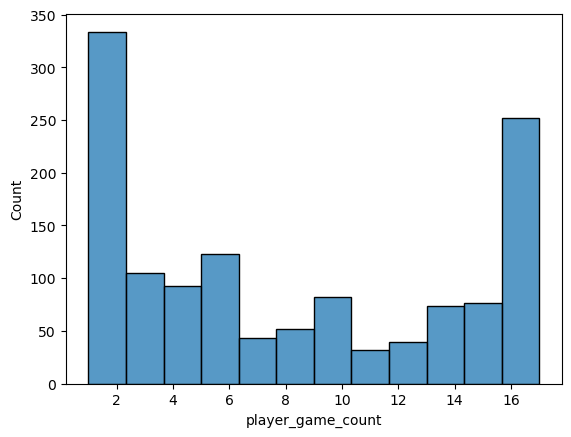

In [17]:
sns.histplot(df, x='player_game_count');

In [18]:
# dict to map team names to abbreviations
team_dict = {'Arizona Cardinals': 'ARZ', 'Atlanta Falcons': 'ATL', 'Baltimore Ravens': 'BLT', 'Buffalo Bills': 'BUF', 
             'Carolina Panthers': 'CAR', 'Chicago Bears': 'CHI', 'Cincinnati Bengals': 'CIN', 'Cleveland Browns': 'CLV', 
             'Dallas Cowboys': 'DAL', 'Denver Broncos': 'DEN', 'Detroit Lions': 'DET', 'Green Bay Packers': 'GB',
             'Houston Texans': 'HST', 'Indianapolis Colts': 'IND', 'Jacksonville Jaguars': 'JAX', 'Kansas City Chiefs': 'KC',
             'Las Vegas Raiders': 'LV', 'Los Angeles Chargers': 'LAC', 'Los Angeles Rams': 'LA', 'Miami Dolphins': 'MIA',
             'Minnesota Vikings': 'MIN', 'New England Patriots': 'NE', 'New Orleans Saints': 'NO', 'New York Giants': 'NYG',
             'New York Jets': 'NYJ', 'Oakland Raiders': 'OAK', 'Philadelphia Eagles': 'PHI', 'Pittsburgh Steelers': 'PIT',
             'San Diego Chargers': 'SD', 'San Francisco 49ers': 'SF', 'Seattle Seahawks': 'SEA', 'St. Louis Rams': 'SL', 
             'Tampa Bay Buccaneers': 'TB', 'Tennessee Titans': 'TEN', 'Washington Commanders': 'WAS', 'Washington Redskins': 
             'WAS'}

In [19]:
from urllib.error import HTTPError
import time

# i was getting a 429 error for placing too many http requests, so i implemented this function
def read_html_with_backoff(url, retries=5, backoff_in_seconds=60):
    for attempt in range(retries):
        try:
            html_tables = pd.read_html(url)
            return html_tables
        except HTTPError as e:
            if e.code == 429:  # too many requests
                print(f"Rate limit hit, backing off for {backoff_in_seconds} seconds.")
                
                # wait for 60 seconds, double wait if error continues
                time.sleep(backoff_in_seconds)
                backoff_in_seconds *= 2
            else:
                raise
    raise Exception("All retries have failed.")

In [20]:
# list to hold all 18 wins dfs
wins_dfs = []

# iterate from 2006-2023
for year in list(range(2006, 2024)):
    # convert year to string
    year_str = str(year)

    # create url string
    url = 'https://www.pro-football-reference.com/years/' + year_str

    # read html table
    html_tables = read_html_with_backoff(url)
    
    # combine the 2 tables, drop unnecessary rows
    wins = pd.concat([html_tables[0], html_tables[1]]).drop([0, 5, 10, 15])

    # clean '*' and '+' from team name
    wins['Tm'] = wins['Tm'].str.replace('*', '', regex=False)
    wins['Tm'] = wins['Tm'].str.replace('+', '', regex=False)

    # add year column
    wins['year'] = year

    # map team name -> abbreviation
    wins['Tm'] = wins['Tm'].map(team_dict)
    
    # add df to list
    wins_dfs.append(wins)

Rate limit hit, backing off for 60 seconds.
Rate limit hit, backing off for 120 seconds.
Rate limit hit, backing off for 240 seconds.
Rate limit hit, backing off for 480 seconds.
Rate limit hit, backing off for 960 seconds.


Exception: All retries have failed.

In [ ]:
wins_dfs

In [ ]:
# stack 18 wins dataframes together
wins_df = pd.concat(wins_dfs, axis=0)

In [ ]:
wins_df

# Experience
- Adding a feature "exp" to represent the player's __years of experience__. For example, a rookie quarterback would have exp=0. 

### QBs who have 2006 data
- Most of these QBs are not rookies
- I will manually input exp for the 2006 season, and then increment years_experience until they retire

In [31]:
# manual input found from research
qbs_2006_exp = [15, 10, 6, 8, 5, 2, 3, 6, 6, 3, 2, 11, 2, 4, 1, 14, 9, 2, 1, 4, 5, 0, 8, 0, 3, 0, 9, 7, 1, 13, 10, 4, 1, 13, 7, 
               7, 3, 12, 13, 3, 0, 7, 1, 3, 6, 5, 11, 0, 4, 3, 8, 5, 5, 8, 2, 13, 4, 3, 1, 5, 0, 1, 0, 19, 12, 7, 6, 3, 4, 0]

# append NaNs to fill out list for all non-2006 players
for _ in range(len(df) - len(qbs_2006_exp)):
    qbs_2006_exp.append(np.nan)

### Add experience col

In [32]:
# add experience col
df['exp'] = qbs_2006_exp

# check
df[['player', 'exp', 'year']]

,player,exp,year
0,Brett Favre,15.0,2006
1,Jon Kitna,10.0,2006
2,Marc Bulger,6.0,2006
3,Peyton Manning,8.0,2006
4,Drew Brees,5.0,2006
...,...,...,...
1300,Mike White,NaN,2023
1301,C.J. Beathard,NaN,2023
1302,Aaron Rodgers,NaN,2023
1303,Jake Browning,NaN,2023


- QBs who played in 2006 season have an exp value, non-2006 QBs have NaN

In [33]:
# function to fill in experience column
def fill_experience(group):
    # get first experience value for a player
    first_exp = group['exp'].iloc[0]
    
    if pd.isna(first_exp): # if value is null we set to 0 (rookie season)
        first_exp = 0
    
    # define range of years to fill each player's experience column
    experience = range(int(first_exp), int(first_exp) + len(group))
    group['exp'] = list(experience)
    return group

# group by index and fill experience values, drop multi-index
# df = df.groupby(level=0).apply(fill_experience).droplevel(0)
df = df.groupby('player').apply(fill_experience).droplevel(0)

In [36]:
df[df['player'] == 'Patrick Mahomes'][['player', 'year', 'exp']]

,player,year,exp
853,Patrick Mahomes,2017,0
875,Patrick Mahomes,2018,1
956,Patrick Mahomes,2019,2
1012,Patrick Mahomes,2020,3
1090,Patrick Mahomes,2021,4
1166,Patrick Mahomes,2022,5
1247,Patrick Mahomes,2023,6


- All players now have a corresponding experience for each of their seasons

# Drop QBs we can't use

### QBs with one season
- QBs with only one season in the dataset will not have a target variable (next season's offensive grade). This means we cannot make predictions.
- However, 2022 rookie QBs (who only have one season in the dataset) can actually be used for generalization. 10/18 weeks of the 2023 NFL season have been played. I will use the grades from the first 10 2023 weeks as a pseudo-target in the final analysis. This allows for a slightly larger test set and will hopefully provide better results.

In [40]:
# get players with only one season
one_season = df.groupby('player').filter(lambda x: len(x) == 1)

# get 2022 rookies, export to csv
rookies_2022 = one_season[one_season['year'] == '2022']
rookies_2022.to_csv('../train_data/rookies_2022.csv')

# drop single season QBs from main dataframe
df = df.drop(one_season.index)
df.shape

(1241, 65)

- Down to 1241 QB seasons

### 2023 season
- 2023 season cannot be input into a model, as there is no 2024 offensive grade target.
- These rows will strictly be kept as a holdout test set.

In [45]:
# 2023 players, export to csv
players_2023 = df[df['year'] == '2023']
players_2023.to_csv('../train_data/players_2023.csv')

# drop 2023 seasons from main dataframe
df = df.drop(players_2023.index)
df.shape

(1193, 65)

- Down to 1193 QB seasons

# Nulls

In [46]:
# look at null counts in each col
df.isna().sum().to_frame().T

,player,team_name,player_game_count,pass_accuracy_percent,pass_aimed_passes,pass_attempts,pass_avg_depth_of_target,pass_avg_time_to_throw,pass_bats,pass_big_time_throws,pass_btt_rate,pass_completion_percent,pass_completions,pass_def_gen_pressures,pass_drop_rate,pass_dropbacks,pass_drops,pass_first_downs,pass_grades_hands_fumble,pass_grades_offense,pass_grades_pass,pass_hit_as_threw,pass_interceptions,pass_passing_snaps,pass_penalties,pass_pressure_to_sack_rate,pass_qb_rating,pass_sack_percent,pass_sacks,pass_scrambles,pass_spikes,pass_thrown_aways,pass_touchdowns,pass_turnover_worthy_plays,pass_twp_rate,pass_yards,pass_ypa,year,rush_attempts,rush_avoided_tackles,rush_breakaway_attempts,rush_breakaway_percent,rush_breakaway_yards,rush_designed_yards,rush_elu_recv_mtf,rush_elu_rush_mtf,rush_elu_yco,rush_elusive_rating,rush_explosive,rush_first_downs,rush_fumbles,rush_gap_attempts,rush_grades_offense_penalty,rush_grades_run,rush_longest,rush_run_plays,rush_scramble_yards,rush_total_touches,rush_touchdowns,rush_yards,rush_yards_after_contact,rush_yco_attempt,rush_ypa,rush_zone_attempts,exp
0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,81,81,81,92,81,81,81,81,128,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,0


- 1 null present in the avg_depth_of_target, 49 nulls present in the rush-statistic columns.
- Null values in these columns indicate 0 attempts for that specific statistic, so these coumns can be filled with 0.

In [47]:
# fill nulls with value of 0
df = df.fillna(0)

# Export data
- Two different modeling approaches require two different datasets

## Non-sequence models
- Each input is a single season, target is next season's offensive grade.
- This means we need players with at least 2 seasons each in the dataset. We already completed this step above, when we dropped 'one_season.index'.

In [50]:
# get copy of df
non_seq = df.copy()

### Target variable
- For each season __x__, the target is the grades_offense stat of season __x + 1__.

In [51]:
# add target col
non_seq['target'] = non_seq.groupby('player')['pass_grades_offense'].shift(-1)

# check
non_seq.head(3)[['player', 'pass_grades_offense', 'target']]

,player,pass_grades_offense,target
52,A.J. Feeley,64.3,41.2
120,A.J. Feeley,41.2,50.0
427,A.J. Feeley,50.0,NaN


- Players in their final season will have a NaN value for the target variable (as seen above).
- These rows cannot be used to train model, as we don't have the grades_offense stat of the next year (it doesn't exist).

### Export non_seq df

In [52]:
# drop rows with null target
non_seq = non_seq.dropna(subset=['target'])

In [54]:
non_seq.shape, len(set(non_seq.player))

((969, 66), 218)

- 'non_seq' df contains 969 QB seasons, each with 64 features + player name + target variable.
- 218 unique QBs.

In [55]:
# export to csv
non_seq.to_csv('../train_data/non_seq.csv')

## Sequence models
- Each input sequence must be of at least length 2, with a 3rd season as a target.
- This means we need players with at least 3 seasons each in the dataset.

In [56]:
# get players with more than 2 seasons
sequence = df.groupby('player').filter(lambda x: len(x) > 2)

### Target variable
- For each pair of two seasons, the target var is the offensive grade of the 3rd season.
- Creating this target variable is more complex, and is handled in the [sequence_model notebook](../notebooks/sequence_model).

### Export sequence df

In [57]:
sequence.shape, len(set(df.player))

((1097, 65), 224)

- 'sequence' df has 1097 QB seasons, each with 64 features + player name.
- This data size will slightly reduce, as several of the sequences will not have a target variable (indicating the final two seasons of a player's career).
- 224 unique QBs.

In [58]:
# export to csv
sequence.to_csv('../train_data/sequence.csv')